In [1]:
!pip install stable-baselines3 torch --quiet

import numpy as np
from stable_baselines3 import TD3  # or TD3, SAC
from stable_baselines3.common.env_checker import check_env
import torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.1 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt

Mounted at /content/drive


In [3]:
TICKER_UNIVERSE = [
    'AAPL', 'MSFT', 'NVDA', 'AVGO', 'ADBE', 'UNH', 'JNJ', 'PFE', 'MRK', 'ABBV',
    'JPM', 'BAC', 'WFC', 'GS', 'MS', 'AMZN', 'TSLA', 'HD', 'MCD', 'NKE', 'GOOGL',
    'META', 'DIS', 'VZ', 'CMCSA', 'PG', 'KO', 'PEP', 'WMT', 'COST', 'XOM', 'CVX',
    'COP', 'BA', 'UNP', 'HON', 'NEE', 'DUK', 'SO', 'PLD', 'AMT', 'CCI', 'SHW', 'DOW'
]
# universe = ['GOOGL', 'TSLA', 'UNH', 'JPM', 'DIS', 'WMT', 'XOM', 'NEE']

In [4]:
technical_df = pd.read_csv('/content/drive/My Drive/LLM_RL_Data/techincal_data/technical_data_cleaned_0321.csv')
sen_df_masked = pd.read_parquet('/content/drive/My Drive/LLM_RL_Data/sentiments_from_sum_masked/AAPL_daily_sentiments.parquet')
sen_df_unmasked = pd.read_parquet('/content/drive/My Drive/LLM_RL_Data/sentiments_from_sum_unmasked/AAPL_daily_sentiments.parquet')

In [5]:
technical_df['volume'] *= technical_df['adjfactor']
technical_df = technical_df.sort_values(by=['ticker', 'date'])

# Create relative volume and volume percent change features
technical_df['volume_MA20'] = technical_df.groupby('ticker')['volume'].transform(lambda x: x.rolling(20).mean())
technical_df['volume_to_MA20'] = technical_df['volume'] / technical_df['volume_MA20'] - 1

technical_df['volume_pct_change'] = technical_df.groupby('ticker')['volume'].transform(lambda x: x.pct_change())
technical_df['vol_5'] = technical_df.groupby('ticker')['return'].transform(lambda x: x.rolling(20).std())
technical_df['vol_20'] = technical_df.groupby('ticker')['return'].transform(lambda x: x.rolling(5).std())

In [6]:
universe = TICKER_UNIVERSE

In [7]:
technical_df.rename(columns={'return': 'returns'}, inplace=True)
technical_df = technical_df[technical_df['ticker'].isin(universe)]
technical_df['date'] = pd.to_datetime(technical_df['date'])
technical_df = technical_df[technical_df['date'] >= '2018-01-01']
technical_df = technical_df.reset_index(drop=True)
technical_df

,ticker,date,adjfactor,open,high,low,close,volume,adj_prc,vwap,returns,SMA_20,EMA_12,RSI_14,EMA_26,MACD,MACD_signal,MACD_hist,BB_Middle,BB_Upper,BB_Lower,GKDailyVar,GKVol,GKVol_21,GKVol_252,RSDailyVar,RSVol,RSVol_21,RSVol_252,volume_MA20,volume_to_MA20,volume_pct_change,vol_5,vol_20
0,AAPL,2018-01-02,4.0,170.16000,172.30,169.25999,172.25999,102223736.0,43.064997,42.8345,0.017905,42.988000,43.004837,48.882802,42.908093,0.096744,0.219766,-0.123022,42.988000,44.136032,41.839968,0.000100,0.010016,0.008161,0.008786,0.000096,0.009802,0.008138,0.008912,1.035413e+08,-0.012725,-0.017105,0.010286,0.016143
1,AAPL,2018-01-03,4.0,172.53000,174.55,171.96001,172.23000,118071600.0,43.057500,43.2743,-0.000174,43.018375,43.012939,51.522121,42.919160,0.093779,0.194569,-0.100790,43.018375,44.138274,41.898475,0.000111,0.010515,0.008023,0.008791,0.000161,0.012686,0.008125,0.008922,1.029329e+08,0.147074,0.155031,0.010127,0.010318
2,AAPL,2018-01-04,4.0,172.53999,173.47,172.08000,173.03000,89738388.0,43.257500,43.2467,0.004645,43.060750,43.050564,52.154205,42.944222,0.106342,0.176923,-0.070582,43.060750,44.147365,41.974135,0.000029,0.005409,0.007938,0.008793,0.000028,0.005324,0.008120,0.008922,1.018896e+08,-0.119259,-0.239966,0.010155,0.010316
3,AAPL,2018-01-05,4.0,173.44000,175.37,173.05000,175.00000,94640072.0,43.750000,43.6718,0.011385,43.135625,43.158169,57.106369,43.003909,0.154260,0.172391,-0.018131,43.135625,44.193741,42.077509,0.000058,0.007596,0.007612,0.008800,0.000049,0.006971,0.007701,0.008928,1.009080e+08,-0.062115,0.054622,0.010342,0.010993
4,AAPL,2018-01-08,4.0,174.35001,175.61,173.92999,174.35001,82271064.0,43.587502,43.6579,-0.003714,43.198500,43.224221,51.029285,43.047138,0.177082,0.173329,0.003753,43.198500,44.203147,42.193853,0.000046,0.006797,0.007060,0.008795,0.000058,0.007594,0.007223,0.008928,9.988685e+07,-0.176357,-0.130695,0.010415,0.008733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73957,XOM,2024-12-24,1.0,106.52000,107.19,105.70000,106.40000,7806997.0,106.400000,106.5536,0.000941,111.943500,108.866587,13.039400,112.219381,-3.352794,-2.797915,-0.554879,111.943500,121.011722,102.875278,0.000097,0.009873,0.009904,0.010937,0.000097,0.009869,0.009587,0.010959,1.726941e+07,-0.547929,-0.364514,0.008893,0.008287
73958,XOM,2024-12-26,1.0,106.52000,107.03,105.94000,106.49000,9653408.0,106.490000,106.4134,0.000846,111.369500,108.500958,9.560976,111.794982,-3.294024,-2.897137,-0.396887,111.369500,120.283563,102.455437,0.000052,0.007236,0.009740,0.010941,0.000052,0.007241,0.009459,0.010963,1.701071e+07,-0.432510,0.236507,0.008640,0.005068
73959,XOM,2024-12-27,1.0,106.30000,107.99,105.77000,106.48000,11943906.0,106.480000,106.7613,-0.000094,110.810500,108.190041,10.828729,111.401280,-3.211238,-2.959957,-0.251281,110.810500,119.461934,102.159066,0.000215,0.014650,0.010128,0.010968,0.000256,0.015986,0.010003,0.010998,1.705395e+07,-0.299640,0.237274,0.008696,0.001799
73960,XOM,2024-12-30,1.0,106.30000,106.56,105.51000,105.76000,11080770.0,105.760000,105.8984,-0.006762,110.200500,107.816189,10.769231,110.983407,-3.167218,-3.001409,-0.165809,110.200500,118.440006,101.960994,0.000039,0.006246,0.010089,0.010966,0.000036,0.006005,0.009946,0.010997,1.713667e+07,-0.353388,-0.072266,0.008521,0.003988


In [8]:
# Define a helper function to load sentiment data for a given ticker
def read_sentiment_data(ticker, masked=True):
    if masked:
        path = f'/content/drive/My Drive/LLM_RL_Data/sentiments_from_sum_masked/{ticker}_daily_sentiments.parquet'
    else:
        path = f'/content/drive/My Drive/LLM_RL_Data/sentiments_from_sum_unmasked/{ticker}_daily_sentiments.parquet'
    df = pd.read_parquet(path)
    # Drop the summary column if present
    if 'summary' in df.columns:
        df = df.drop(columns=['summary'])
    # Add ticker column for merging
    df['ticker'] = ticker
    df['date'] = pd.to_datetime(df['date'])
    return df

# Define an in-sample cutoff date (for example, use 2020-12-31)
insample_end = pd.to_datetime("2023-12-31")

# Load and combine sentiment data for each ticker in the universe
sentiment_list = []
for ticker in universe:
    # Read masked sentiment (for in-sample)
    df_masked = read_sentiment_data(ticker, masked=True)
    # Read unmasked sentiment (for out-of-sample)
    df_unmasked = read_sentiment_data(ticker, masked=False)

    # Select rows based on date:
    # For dates <= insample_end use masked, otherwise use unmasked
    df_combined = pd.concat([
        df_masked[df_masked['date'] <= insample_end],
        df_unmasked[df_unmasked['date'] > insample_end]
    ], ignore_index=True)

    sentiment_list.append(df_combined)

# Concatenate sentiment data for all tickers
sentiments_df = pd.concat(sentiment_list, ignore_index=True)

# Merge technical and sentiment data on ticker and date (left join to retain technical data)
technical_df = pd.merge(technical_df, sentiments_df, on=['ticker', 'date'], how='left')


In [9]:
technical_df

,ticker,date,adjfactor,open,high,low,close,volume,adj_prc,vwap,returns,SMA_20,EMA_12,RSI_14,EMA_26,MACD,MACD_signal,MACD_hist,BB_Middle,BB_Upper,BB_Lower,GKDailyVar,GKVol,GKVol_21,GKVol_252,RSDailyVar,RSVol,RSVol_21,RSVol_252,volume_MA20,volume_to_MA20,volume_pct_change,vol_5,vol_20,sentiment,confidence
0,AAPL,2018-01-02,4.0,170.16000,172.30,169.25999,172.25999,102223736.0,43.064997,42.8345,0.017905,42.988000,43.004837,48.882802,42.908093,0.096744,0.219766,-0.123022,42.988000,44.136032,41.839968,0.000100,0.010016,0.008161,0.008786,0.000096,0.009802,0.008138,0.008912,1.035413e+08,-0.012725,-0.017105,0.010286,0.016143,Positive,0.768355
1,AAPL,2018-01-03,4.0,172.53000,174.55,171.96001,172.23000,118071600.0,43.057500,43.2743,-0.000174,43.018375,43.012939,51.522121,42.919160,0.093779,0.194569,-0.100790,43.018375,44.138274,41.898475,0.000111,0.010515,0.008023,0.008791,0.000161,0.012686,0.008125,0.008922,1.029329e+08,0.147074,0.155031,0.010127,0.010318,Neutral,1.000000
2,AAPL,2018-01-04,4.0,172.53999,173.47,172.08000,173.03000,89738388.0,43.257500,43.2467,0.004645,43.060750,43.050564,52.154205,42.944222,0.106342,0.176923,-0.070582,43.060750,44.147365,41.974135,0.000029,0.005409,0.007938,0.008793,0.000028,0.005324,0.008120,0.008922,1.018896e+08,-0.119259,-0.239966,0.010155,0.010316,Positive,0.847346
3,AAPL,2018-01-05,4.0,173.44000,175.37,173.05000,175.00000,94640072.0,43.750000,43.6718,0.011385,43.135625,43.158169,57.106369,43.003909,0.154260,0.172391,-0.018131,43.135625,44.193741,42.077509,0.000058,0.007596,0.007612,0.008800,0.000049,0.006971,0.007701,0.008928,1.009080e+08,-0.062115,0.054622,0.010342,0.010993,Positive,0.845315
4,AAPL,2018-01-08,4.0,174.35001,175.61,173.92999,174.35001,82271064.0,43.587502,43.6579,-0.003714,43.198500,43.224221,51.029285,43.047138,0.177082,0.173329,0.003753,43.198500,44.203147,42.193853,0.000046,0.006797,0.007060,0.008795,0.000058,0.007594,0.007223,0.008928,9.988685e+07,-0.176357,-0.130695,0.010415,0.008733,Negative,0.705211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73957,XOM,2024-12-24,1.0,106.52000,107.19,105.70000,106.40000,7806997.0,106.400000,106.5536,0.000941,111.943500,108.866587,13.039400,112.219381,-3.352794,-2.797915,-0.554879,111.943500,121.011722,102.875278,0.000097,0.009873,0.009904,0.010937,0.000097,0.009869,0.009587,0.010959,1.726941e+07,-0.547929,-0.364514,0.008893,0.008287,Neutral,0.566318
73958,XOM,2024-12-26,1.0,106.52000,107.03,105.94000,106.49000,9653408.0,106.490000,106.4134,0.000846,111.369500,108.500958,9.560976,111.794982,-3.294024,-2.897137,-0.396887,111.369500,120.283563,102.455437,0.000052,0.007236,0.009740,0.010941,0.000052,0.007241,0.009459,0.010963,1.701071e+07,-0.432510,0.236507,0.008640,0.005068,Positive,0.474156
73959,XOM,2024-12-27,1.0,106.30000,107.99,105.77000,106.48000,11943906.0,106.480000,106.7613,-0.000094,110.810500,108.190041,10.828729,111.401280,-3.211238,-2.959957,-0.251281,110.810500,119.461934,102.159066,0.000215,0.014650,0.010128,0.010968,0.000256,0.015986,0.010003,0.010998,1.705395e+07,-0.299640,0.237274,0.008696,0.001799,Neutral,0.612530
73960,XOM,2024-12-30,1.0,106.30000,106.56,105.51000,105.76000,11080770.0,105.760000,105.8984,-0.006762,110.200500,107.816189,10.769231,110.983407,-3.167218,-3.001409,-0.165809,110.200500,118.440006,101.960994,0.000039,0.006246,0.010089,0.010966,0.000036,0.006005,0.009946,0.010997,1.713667e+07,-0.353388,-0.072266,0.008521,0.003988,Neutral,1.000000


In [10]:
technical_df['sentiment'] = technical_df['sentiment'].fillna('Neutral')
technical_df['confidence'] = technical_df['confidence'].fillna(1.0)
technical_df

,ticker,date,adjfactor,open,high,low,close,volume,adj_prc,vwap,returns,SMA_20,EMA_12,RSI_14,EMA_26,MACD,MACD_signal,MACD_hist,BB_Middle,BB_Upper,BB_Lower,GKDailyVar,GKVol,GKVol_21,GKVol_252,RSDailyVar,RSVol,RSVol_21,RSVol_252,volume_MA20,volume_to_MA20,volume_pct_change,vol_5,vol_20,sentiment,confidence
0,AAPL,2018-01-02,4.0,170.16000,172.30,169.25999,172.25999,102223736.0,43.064997,42.8345,0.017905,42.988000,43.004837,48.882802,42.908093,0.096744,0.219766,-0.123022,42.988000,44.136032,41.839968,0.000100,0.010016,0.008161,0.008786,0.000096,0.009802,0.008138,0.008912,1.035413e+08,-0.012725,-0.017105,0.010286,0.016143,Positive,0.768355
1,AAPL,2018-01-03,4.0,172.53000,174.55,171.96001,172.23000,118071600.0,43.057500,43.2743,-0.000174,43.018375,43.012939,51.522121,42.919160,0.093779,0.194569,-0.100790,43.018375,44.138274,41.898475,0.000111,0.010515,0.008023,0.008791,0.000161,0.012686,0.008125,0.008922,1.029329e+08,0.147074,0.155031,0.010127,0.010318,Neutral,1.000000
2,AAPL,2018-01-04,4.0,172.53999,173.47,172.08000,173.03000,89738388.0,43.257500,43.2467,0.004645,43.060750,43.050564,52.154205,42.944222,0.106342,0.176923,-0.070582,43.060750,44.147365,41.974135,0.000029,0.005409,0.007938,0.008793,0.000028,0.005324,0.008120,0.008922,1.018896e+08,-0.119259,-0.239966,0.010155,0.010316,Positive,0.847346
3,AAPL,2018-01-05,4.0,173.44000,175.37,173.05000,175.00000,94640072.0,43.750000,43.6718,0.011385,43.135625,43.158169,57.106369,43.003909,0.154260,0.172391,-0.018131,43.135625,44.193741,42.077509,0.000058,0.007596,0.007612,0.008800,0.000049,0.006971,0.007701,0.008928,1.009080e+08,-0.062115,0.054622,0.010342,0.010993,Positive,0.845315
4,AAPL,2018-01-08,4.0,174.35001,175.61,173.92999,174.35001,82271064.0,43.587502,43.6579,-0.003714,43.198500,43.224221,51.029285,43.047138,0.177082,0.173329,0.003753,43.198500,44.203147,42.193853,0.000046,0.006797,0.007060,0.008795,0.000058,0.007594,0.007223,0.008928,9.988685e+07,-0.176357,-0.130695,0.010415,0.008733,Negative,0.705211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73957,XOM,2024-12-24,1.0,106.52000,107.19,105.70000,106.40000,7806997.0,106.400000,106.5536,0.000941,111.943500,108.866587,13.039400,112.219381,-3.352794,-2.797915,-0.554879,111.943500,121.011722,102.875278,0.000097,0.009873,0.009904,0.010937,0.000097,0.009869,0.009587,0.010959,1.726941e+07,-0.547929,-0.364514,0.008893,0.008287,Neutral,0.566318
73958,XOM,2024-12-26,1.0,106.52000,107.03,105.94000,106.49000,9653408.0,106.490000,106.4134,0.000846,111.369500,108.500958,9.560976,111.794982,-3.294024,-2.897137,-0.396887,111.369500,120.283563,102.455437,0.000052,0.007236,0.009740,0.010941,0.000052,0.007241,0.009459,0.010963,1.701071e+07,-0.432510,0.236507,0.008640,0.005068,Positive,0.474156
73959,XOM,2024-12-27,1.0,106.30000,107.99,105.77000,106.48000,11943906.0,106.480000,106.7613,-0.000094,110.810500,108.190041,10.828729,111.401280,-3.211238,-2.959957,-0.251281,110.810500,119.461934,102.159066,0.000215,0.014650,0.010128,0.010968,0.000256,0.015986,0.010003,0.010998,1.705395e+07,-0.299640,0.237274,0.008696,0.001799,Neutral,0.612530
73960,XOM,2024-12-30,1.0,106.30000,106.56,105.51000,105.76000,11080770.0,105.760000,105.8984,-0.006762,110.200500,107.816189,10.769231,110.983407,-3.167218,-3.001409,-0.165809,110.200500,118.440006,101.960994,0.000039,0.006246,0.010089,0.010966,0.000036,0.006005,0.009946,0.010997,1.713667e+07,-0.353388,-0.072266,0.008521,0.003988,Neutral,1.000000


In [11]:
technical_df.columns

Index(['ticker', 'date', 'adjfactor', 'open', 'high', 'low', 'close', 'volume',
       'adj_prc', 'vwap', 'returns', 'SMA_20', 'EMA_12', 'RSI_14', 'EMA_26',
       'MACD', 'MACD_signal', 'MACD_hist', 'BB_Middle', 'BB_Upper', 'BB_Lower',
       'GKDailyVar', 'GKVol', 'GKVol_21', 'GKVol_252', 'RSDailyVar', 'RSVol',
       'RSVol_21', 'RSVol_252', 'volume_MA20', 'volume_to_MA20',
       'volume_pct_change', 'vol_5', 'vol_20', 'sentiment', 'confidence'],
      dtype='object')

In [12]:
technical_df['close_vwap'] = technical_df['adj_prc']/technical_df['vwap'] - 1
technical_df['close_SMA_20'] = technical_df['adj_prc']/technical_df['SMA_20'] - 1
technical_df['GK_GK21'] = technical_df['GKVol']/technical_df['GKVol_21'] - 1
# technical_df['RS/RS21'] = technical_df['RSVol']/technical_df['GKVol_21'] - 1
technical_df['GK21_GK252'] = technical_df['GKVol_21']/technical_df['GKVol_252'] - 1
# technical_df['RS21/RS252'] = technical_df['RSVol_21']/technical_df['RSVol_252'] - 1
technical_df['volume']/= 1000000
technical_df['RSI_14'] = technical_df['RSI_14']/50 - 1
technical_df['vol5_vol20'] = technical_df['vol_5']/technical_df['vol_20'] - 1

In [13]:
technical_df['sentiment'] = technical_df['sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1})
technical_df['sentiment'] = technical_df['sentiment'] * technical_df['confidence']

In [14]:
technical_df.columns

Index(['ticker', 'date', 'adjfactor', 'open', 'high', 'low', 'close', 'volume',
       'adj_prc', 'vwap', 'returns', 'SMA_20', 'EMA_12', 'RSI_14', 'EMA_26',
       'MACD', 'MACD_signal', 'MACD_hist', 'BB_Middle', 'BB_Upper', 'BB_Lower',
       'GKDailyVar', 'GKVol', 'GKVol_21', 'GKVol_252', 'RSDailyVar', 'RSVol',
       'RSVol_21', 'RSVol_252', 'volume_MA20', 'volume_to_MA20',
       'volume_pct_change', 'vol_5', 'vol_20', 'sentiment', 'confidence',
       'close_vwap', 'close_SMA_20', 'GK_GK21', 'GK21_GK252', 'vol5_vol20'],
      dtype='object')

In [15]:
technical_df

,ticker,date,adjfactor,open,high,low,close,volume,adj_prc,vwap,returns,SMA_20,EMA_12,RSI_14,EMA_26,MACD,MACD_signal,MACD_hist,BB_Middle,BB_Upper,BB_Lower,GKDailyVar,GKVol,GKVol_21,GKVol_252,RSDailyVar,RSVol,RSVol_21,RSVol_252,volume_MA20,volume_to_MA20,volume_pct_change,vol_5,vol_20,sentiment,confidence,close_vwap,close_SMA_20,GK_GK21,GK21_GK252,vol5_vol20
0,AAPL,2018-01-02,4.0,170.16000,172.30,169.25999,172.25999,102.223736,43.064997,42.8345,0.017905,42.988000,43.004837,-0.022344,42.908093,0.096744,0.219766,-0.123022,42.988000,44.136032,41.839968,0.000100,0.010016,0.008161,0.008786,0.000096,0.009802,0.008138,0.008912,1.035413e+08,-0.012725,-0.017105,0.010286,0.016143,0.768355,0.768355,0.005381,0.001791,0.227257,-0.071096,-0.362790
1,AAPL,2018-01-03,4.0,172.53000,174.55,171.96001,172.23000,118.071600,43.057500,43.2743,-0.000174,43.018375,43.012939,0.030442,42.919160,0.093779,0.194569,-0.100790,43.018375,44.138274,41.898475,0.000111,0.010515,0.008023,0.008791,0.000161,0.012686,0.008125,0.008922,1.029329e+08,0.147074,0.155031,0.010127,0.010318,0.000000,1.000000,-0.005010,0.000909,0.310632,-0.087360,-0.018506
2,AAPL,2018-01-04,4.0,172.53999,173.47,172.08000,173.03000,89.738388,43.257500,43.2467,0.004645,43.060750,43.050564,0.043084,42.944222,0.106342,0.176923,-0.070582,43.060750,44.147365,41.974135,0.000029,0.005409,0.007938,0.008793,0.000028,0.005324,0.008120,0.008922,1.018896e+08,-0.119259,-0.239966,0.010155,0.010316,0.847346,0.847346,0.000250,0.004569,-0.318571,-0.097290,-0.015647
3,AAPL,2018-01-05,4.0,173.44000,175.37,173.05000,175.00000,94.640072,43.750000,43.6718,0.011385,43.135625,43.158169,0.142127,43.003909,0.154260,0.172391,-0.018131,43.135625,44.193741,42.077509,0.000058,0.007596,0.007612,0.008800,0.000049,0.006971,0.007701,0.008928,1.009080e+08,-0.062115,0.054622,0.010342,0.010993,0.845315,0.845315,0.001791,0.014243,-0.002064,-0.134972,-0.059220
4,AAPL,2018-01-08,4.0,174.35001,175.61,173.92999,174.35001,82.271064,43.587502,43.6579,-0.003714,43.198500,43.224221,0.020586,43.047138,0.177082,0.173329,0.003753,43.198500,44.203147,42.193853,0.000046,0.006797,0.007060,0.008795,0.000058,0.007594,0.007223,0.008928,9.988685e+07,-0.176357,-0.130695,0.010415,0.008733,-0.705211,0.705211,-0.001612,0.009005,-0.037198,-0.197278,0.192693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73957,XOM,2024-12-24,1.0,106.52000,107.19,105.70000,106.40000,7.806997,106.400000,106.5536,0.000941,111.943500,108.866587,-0.739212,112.219381,-3.352794,-2.797915,-0.554879,111.943500,121.011722,102.875278,0.000097,0.009873,0.009904,0.010937,0.000097,0.009869,0.009587,0.010959,1.726941e+07,-0.547929,-0.364514,0.008893,0.008287,0.000000,0.566318,-0.001442,-0.049521,-0.003148,-0.094390,0.073128
73958,XOM,2024-12-26,1.0,106.52000,107.03,105.94000,106.49000,9.653408,106.490000,106.4134,0.000846,111.369500,108.500958,-0.808780,111.794982,-3.294024,-2.897137,-0.396887,111.369500,120.283563,102.455437,0.000052,0.007236,0.009740,0.010941,0.000052,0.007241,0.009459,0.010963,1.701071e+07,-0.432510,0.236507,0.008640,0.005068,0.474156,0.474156,0.000720,-0.043814,-0.257084,-0.109809,0.704678
73959,XOM,2024-12-27,1.0,106.30000,107.99,105.77000,106.48000,11.943906,106.480000,106.7613,-0.000094,110.810500,108.190041,-0.783425,111.401280,-3.211238,-2.959957,-0.251281,110.810500,119.461934,102.159066,0.000215,0.014650,0.010128,0.010968,0.000256,0.015986,0.010003,0.010998,1.705395e+07,-0.299640,0.237274,0.008696,0.001799,0.000000,0.612530,-0.002635,-0.039080,0.446482,-0.076617,3.834339
73960,XOM,2024-12-30,1.0,106.30000,106.56,105.51000,105.76000,11.080770,105.760000,105.8984,-0.006762,110.200500,107.816189,-0.784615,110.983407,-3.167218,-3.001409,-0.165809,110.200500,118.440006,101.960994,0.000039,0.006246,0.010089,0.010966,0.000036,0.006005,0.009946,0.010997,1.713667e+07,-0.353388,-0.072266,0.008521,0.003988,0.000000,1.000000,-0.001307,-0.040295,-0.3809

In [16]:
technical_df.drop(columns=['adj_prc','vwap','open', 'high', 'low', 'close', 'SMA_20', 'EMA_12','EMA_26',
                           'MACD_signal', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'volume_MA20','volume','MACD_hist',
                           'GKVol_252', 'RSVol', 'RSVol_252','adjfactor','GKDailyVar','RSDailyVar','RSVol_21','confidence','close_vwap','close_SMA_20',
                           'GK_GK21','GK21_GK252','GKVol_21','volume_pct_change','vol_5','vol_20'], inplace=True)
technical_df

,ticker,date,returns,RSI_14,MACD,GKVol,volume_to_MA20,sentiment,vol5_vol20
0,AAPL,2018-01-02,0.017905,-0.022344,0.096744,0.010016,-0.012725,0.768355,-0.362790
1,AAPL,2018-01-03,-0.000174,0.030442,0.093779,0.010515,0.147074,0.000000,-0.018506
2,AAPL,2018-01-04,0.004645,0.043084,0.106342,0.005409,-0.119259,0.847346,-0.015647
3,AAPL,2018-01-05,0.011385,0.142127,0.154260,0.007596,-0.062115,0.845315,-0.059220
4,AAPL,2018-01-08,-0.003714,0.020586,0.177082,0.006797,-0.176357,-0.705211,0.192693
...,...,...,...,...,...,...,...,...,...
73957,XOM,2024-12-24,0.000941,-0.739212,-3.352794,0.009873,-0.547929,0.000000,0.073128
73958,XOM,2024-12-26,0.000846,-0.808780,-3.294024,0.007236,-0.432510,0.474156,0.704678
73959,XOM,2024-12-27,-0.000094,-0.783425,-3.211238,0.014650,-0.299640,0.000000,3.834339
73960,XOM,2024-12-30,-0.006762,-0.784615,-3.167218,0.006246,-0.353388,0.000000,1.136631


In [17]:
# features_to_normalize = ['RSI_14', 'MACD', 'volume_to_MA20', 'vol5_vol20']

# # Function to normalize the selected features cross-sectionally per day
# def normalize_features(df):
#     # Group by date and normalize each feature
#     df[features_to_normalize] = df.groupby('date')[features_to_normalize].transform(
#         lambda x: (x - x.mean()) / x.std()
#     )
#     return df

# # Assuming technical_df is your DataFrame:
# technical_df = normalize_features(technical_df)
# technical_df

In [18]:
technical_df.describe()

,date,returns,RSI_14,MACD,GKVol,volume_to_MA20,sentiment,vol5_vol20
count,73962,73962.000000,73962.000000,73962.000000,73962.000000,73962.000000,73962.000000,73962.000000
mean,2021-07-01 15:36:17.172061184,0.000613,0.056352,0.495313,0.013361,0.009096,0.140664,0.302702
min,2018-01-02 00:00:00,-0.263901,-0.974497,-57.219849,0.001935,-0.856887,-0.999897,-0.531204
25%,2019-10-02 00:00:00,-0.008113,-0.185185,-0.719644,0.008242,-0.231288,0.000000,-0.155363
50%,2021-07-01 00:00:00,0.000680,0.061934,0.303447,0.011215,-0.073629,0.000000,0.100486
75%,2023-03-31 00:00:00,0.009422,0.305872,1.571113,0.015806,0.139372,0.482774,0.508084
max,2024-12-31 00:00:00,0.252138,1.000000,40.538607,0.263818,8.772747,0.999921,19.777609
std,NaN,0.019801,0.340203,3.814583,0.008656,0.405999,0.395686,0.773509


In [19]:
# technical_df['MACD_signal'] = technical_df['MACD'] * abs(technical_df['MACD_hist'])
# technical_df.drop(columns = ['MACD','MACD_hist'],inplace = True)


In [20]:
technical_df

,ticker,date,returns,RSI_14,MACD,GKVol,volume_to_MA20,sentiment,vol5_vol20
0,AAPL,2018-01-02,0.017905,-0.022344,0.096744,0.010016,-0.012725,0.768355,-0.362790
1,AAPL,2018-01-03,-0.000174,0.030442,0.093779,0.010515,0.147074,0.000000,-0.018506
2,AAPL,2018-01-04,0.004645,0.043084,0.106342,0.005409,-0.119259,0.847346,-0.015647
3,AAPL,2018-01-05,0.011385,0.142127,0.154260,0.007596,-0.062115,0.845315,-0.059220
4,AAPL,2018-01-08,-0.003714,0.020586,0.177082,0.006797,-0.176357,-0.705211,0.192693
...,...,...,...,...,...,...,...,...,...
73957,XOM,2024-12-24,0.000941,-0.739212,-3.352794,0.009873,-0.547929,0.000000,0.073128
73958,XOM,2024-12-26,0.000846,-0.808780,-3.294024,0.007236,-0.432510,0.474156,0.704678
73959,XOM,2024-12-27,-0.000094,-0.783425,-3.211238,0.014650,-0.299640,0.000000,3.834339
73960,XOM,2024-12-30,-0.006762,-0.784615,-3.167218,0.006246,-0.353388,0.000000,1.136631


In [21]:
import numpy as np
import pandas as pd

def prepare_data(df, start_date, end_date, tickers, feature_cols):
    """
    Filters df by [start_date, end_date] and tickers, then organizes
    daily features and returns for each ticker in a consistent shape.

    Returns:
        date_array (1D np.array of shape [T]): The unique, sorted dates in the range.
        feature_array (3D np.array of shape [T, n_tickers, n_features]):
                      Features for each day, each ticker.
        return_array (2D np.array of shape [T, n_tickers]):
                      Realized daily returns for each ticker.
    """
    mask = (df['date'] >= start_date) & (df['date'] <= end_date) & (df['ticker'].isin(tickers))
    sub = df.loc[mask].copy()

    # 1) Sort by date, ticker to keep a consistent order
    sub.sort_values(by=['date','ticker'], inplace=True)

    # 2) List out the unique dates in ascending order
    unique_dates = sub['date'].unique()

    # 3) We will build 3D feature array: [time, ticker_index, feature_dim]
    #    We also build 2D return array: [time, ticker_index]
    n_dates = len(unique_dates)
    n_tickers = len(tickers)
    n_features = len(feature_cols)

    feature_array = np.zeros((n_dates, n_tickers, n_features), dtype=np.float32)
    return_array  = np.zeros((n_dates, n_tickers), dtype=np.float32)

    # Create a map from ticker -> index
    ticker_to_idx = {t: i for i, t in enumerate(tickers)}

    # Fill in the arrays
    for t_i, day in enumerate(unique_dates):
        # All rows for this specific date
        day_rows = sub[sub['date'] == day]
        for row in day_rows.itertuples(index=False):
            # row is a namedtuple with columns from df
            # row.ticker, row.date, row.return, row.RSI_14, ...
            idx = ticker_to_idx[row.ticker]
            # print(feature_cols)
            feats = [getattr(row, c) for c in feature_cols]
            feature_array[t_i, idx, :] = feats
            return_array[t_i, idx] = row.returns

    return unique_dates, feature_array, return_array






In [22]:
# Choose the tickers you want in your universe
all_tickers = sorted(technical_df['ticker'].unique())
feature_cols = list(technical_df.columns[2:])

train_end_date = '2022-12-31'
oos1_start_date = '2023-01-01'
oos1_end_date   = '2023-12-31'
oos2_start_date = '2024-01-01'
oos2_end_date   = '2024-12-31'

# 1) Training set
train_dates, train_features, train_returns = prepare_data(
    technical_df,
    start_date=technical_df['date'].min(),
    end_date=train_end_date,
    tickers=all_tickers,
    feature_cols=feature_cols
)

# 2) OOS1
oos1_dates,  oos1_features,  oos1_returns  = prepare_data(
    technical_df, oos1_start_date, oos1_end_date, all_tickers, feature_cols
)

# 3) OOS2
oos2_dates,  oos2_features,  oos2_returns  = prepare_data(
    technical_df, oos2_start_date, oos2_end_date, all_tickers, feature_cols
)

In [23]:
rf_rate = pd.read_csv('/content/drive/My Drive/LLM_RL_Data/risk_free_data/TB3MS.csv')
rf_rate[rf_rate.columns[0]] = pd.to_datetime(rf_rate[rf_rate.columns[0]], errors='coerce').dt.strftime('%Y-%m-%d')

# Rename the columns to "date" and "rf_rate"
rf_rate.columns = ['date', 'rf_rate']
# rf_rate['rf_rate'] = rf_rate['rf_rate'] /
rf_rate

,date,rf_rate
0,2018-01-01,1.41
1,2018-02-01,1.57
2,2018-03-01,1.70
3,2018-04-01,1.76
4,2018-05-01,1.86
...,...,...
81,2024-10-01,4.51
82,2024-11-01,4.42
83,2024-12-01,4.27
84,2025-01-01,4.21


In [24]:
monthly_rf = rf_rate.copy()
monthly_rf['date'] = pd.to_datetime(monthly_rf['date'])
monthly_rf['month'] = monthly_rf['date'].dt.to_period('M')
unique_dates = pd.DataFrame(technical_df.date.unique())
unique_dates = pd.DataFrame(technical_df.date.unique())
unique_dates['date'] = pd.to_datetime(unique_dates[0])  # ensure datetime
unique_dates['month'] = unique_dates['date'].dt.to_period('M')
unique_dates.drop(columns=[0], inplace=True)
merged_df = pd.merge(
    unique_dates,
    monthly_rf[['month', 'rf_rate']],  # only need month and rf_rate
    on='month',
    how='left'
)

# Keep just date, rf_rate; sort by date
merged_df = merged_df[['date', 'rf_rate']].sort_values('date')
merged_df['rf_rate'] = merged_df['rf_rate'] / 100 / 252

In [25]:
rf_train = merged_df[merged_df['date'] <= train_end_date]['rf_rate'].values
rf_oos1 = merged_df[(merged_df['date'] > train_end_date) & (merged_df['date'] <= oos1_end_date)]['rf_rate'].values
rf_oos2 = merged_df[(merged_df['date'] > oos1_end_date) & (merged_df['date'] <= oos2_end_date)]['rf_rate'].values
rf_train

array([5.59523810e-05, 5.59523810e-05, 5.59523810e-05, ...,
       1.68650794e-04, 1.68650794e-04, 1.68650794e-04])

In [26]:
train_bench_mark_returns = train_returns.mean(axis=1)
oos1_bench_mark_returns = oos1_returns.mean(axis=1)
oos2_bench_mark_returns = oos2_returns.mean(axis=1)

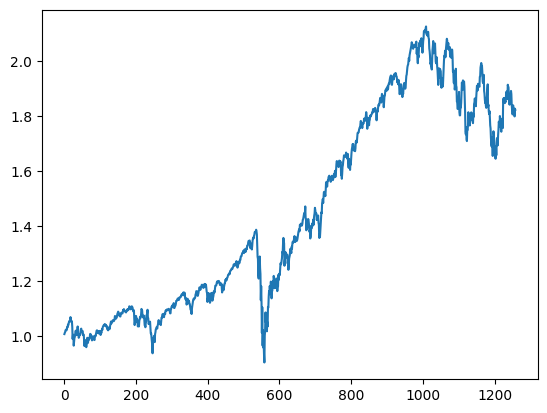

In [27]:
plt.plot(np.cumprod(1+train_bench_mark_returns))

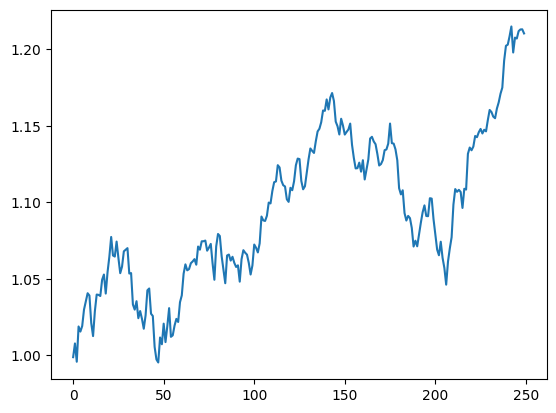

In [28]:
plt.plot(np.cumprod(1+oos1_bench_mark_returns))

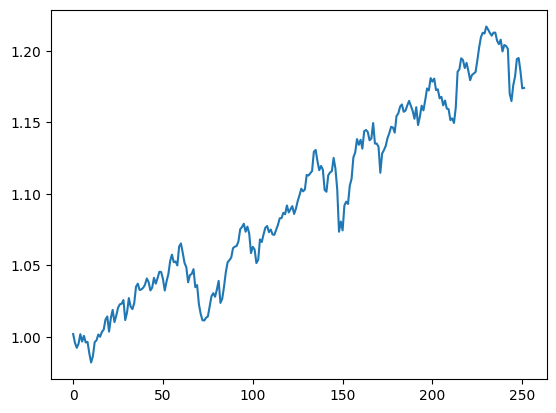

In [29]:
plt.plot(np.cumprod(1+oos2_bench_mark_returns))

## model

In [30]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class PortfolioEnv(gym.Env):
    """
    Illustrates a day-by-day environment where:
      - Action at day t -> final weights w_t.
      - Day t returns => reward from w_t.
      - End of day t, we compute intermediate weights_{t+1} after returns.
      - Next observation includes (features_{t+1}, intermediate_weights_{t+1}).
    """
    def __init__(self,
                 feature_array,    # shape [T, n_stocks, n_features]
                 return_array,     # shape [T, n_stocks]
                 rf_rate,          # new: riskfree rate array; must align with T (daily rates)
                 long_short=False,
                 short_limit=1.0,     # e.g., 0.7 => up to 70% short
                 borrow_cost=0.01,    # 1% annual for short (converted internally to daily)
                 transaction_cost=0.00,  # e.g., 0.1% annual => ~0.001 daily
                 initial_capital=1_000_000):
        super(PortfolioEnv, self).__init__()

        self.feature_array = feature_array
        self.return_array  = return_array
        self.rf_rate = rf_rate  # now a daily series of riskfree rates
        self.T, self.n_stocks, self.n_features = feature_array.shape

        # Use provided riskfree rate (assumed daily) per step.
        # For costs, we still treat them as annual rates scaled to daily:
        self.daily_bcost = borrow_cost / 252.
        self.daily_tcost = transaction_cost  # can be scaled if needed

        self.long_short = long_short
        self.short_limit = short_limit

        self.initial_capital = float(initial_capital)
        self._current_step = 0

        # For long-short, split capital according to short_limit
        if self.long_short:
            self.long_capital  = self.initial_capital * (1.0 / (1.0 + self.short_limit))
            self.short_capital = self.initial_capital * (self.short_limit / (1.0 + self.short_limit))
        else:
            self.long_capital  = self.initial_capital
            self.short_capital = 0.0


        # Observation space: flattened features + current weights (n_stocks+1)
        obs_dim = self.n_stocks*self.n_features + (self.n_stocks+1)
        self.observation_space = spaces.Box(
            low=-100.0, high=100.0, shape=(obs_dim,), dtype=np.float32
        )

        # Action space: raw "preferences" for each of the n_stocks+1; will be projected
        self.action_space = spaces.Box(
            low=0.0, high=10.0, shape=(self.n_stocks+1,), dtype=np.float32
        )

        # Internal variables
        self.weights = None  # shape [n_stocks+1], w[0]=cash, w[1:]=stocks
        self.portfolio_value = None

        # For logging
        self.history_rewards = []
        self.history_weights = []
        self.history_actions = []
        self.history_action_weights = []  # new: record of projected action weights
        self.history_turnovers = []       # new: record of turnover rates

    def reset(self, seed=None, options=None):
        """Start at day 0 with full cash allocation (100% cash)."""
        super().reset(seed=seed)

        self._current_step = 0
        self.portfolio_value = self.initial_capital

        # Start fully in cash
        all_cash = np.zeros(self.n_stocks+1, dtype=np.float32)
        all_cash[0] = 1.0
        self.weights = all_cash.copy()

        # Reset logging histories
        self.history_rewards = []
        self.history_weights = []
        self.history_actions = []
        self.history_action_weights = []
        self.history_turnovers = []

        obs = self._get_observation()
        info = {}
        return obs, info

    def _get_observation(self):
        """
        Observation at day t includes:
          - features for day t: shape [n_stocks, n_features] flattened
          - intermediate weights at day t: shape [n_stocks+1]
        """
        feats_flat = self.feature_array[self._current_step].flatten()
        obs = np.concatenate([feats_flat, self.weights], axis=0)
        return obs.astype(np.float32)

    def step(self, action):
        """
        Step logic:
          1) Use the previous day's weights (intermediate weights) which have earned returns.
          2) The agent provides a new action which is projected into valid portfolio weights.
          3) Apply transaction and short costs.
          4) Update portfolio value based on asset returns and update weights.
        """
        # 1) Get current intermediate weights
        intermediate_weight_t = self.weights

        # 2) Project raw action into valid portfolio weights
        action_weight_t = self._project_action(action)

        # Calculate turnover: absolute difference between new and current weights
        turnover = np.sum(np.abs(action_weight_t[1:] - intermediate_weight_t[1:]))
        # turnover = np.sum(np.abs(action_weight_t - intermediate_weight_t))
        tcost = turnover * self.daily_tcost

        # Compute short borrowing cost if in long-short mode
        if self.long_short:
            short_exposure = np.sum(np.clip(action_weight_t[1:], a_min=None, a_max=0.0))
            short_cost = -short_exposure * self.daily_bcost
        else:
            short_cost = 0.0

        # Record the projected action weights and turnover rate
        self.history_action_weights.append(action_weight_t.copy())
        self.history_turnovers.append(turnover)

        # 3) Transition to next time step
        self._current_step += 1
        returns_t1 = self.return_array[self._current_step]
        # Use the riskfree rate for the current step (assumed to be daily)
        current_rf = self.rf_rate[self._current_step]
        intermediate_cash_t1 = action_weight_t[0] * (1 + current_rf)
        intermediate_stock_t1 = action_weight_t[1:] * (1 + returns_t1)
        intermediate_total_t1 = intermediate_cash_t1 + np.sum(intermediate_stock_t1)
        intermediate_weights_t1 = np.concatenate([
            [intermediate_cash_t1 / intermediate_total_t1],
            intermediate_stock_t1 / intermediate_total_t1
        ])
        weight_after_adj = np.concatenate([
            [intermediate_cash_t1],
            intermediate_stock_t1
        ])

        # Compute raw daily return fraction and adjust for costs
        raw_return_fraction = (intermediate_total_t1 / np.sum(action_weight_t)) - 1.0
        net_return_fraction = raw_return_fraction - tcost - short_cost

        # Update portfolio value
        self.portfolio_value *= (1.0 + net_return_fraction)

        # 4) Update environment state and log histories
        reward = net_return_fraction
        self.weights = intermediate_weights_t1
        done = (self._current_step >= (self.T - 1))

        self.history_rewards.append(reward)
        self.history_weights.append(intermediate_weights_t1.copy())
        self.history_actions.append(action.copy())

        if not done:
            next_obs = self._get_observation()
        else:
            next_obs = np.zeros_like(self._get_observation())

        info = {
            "portfolio_value": self.portfolio_value,
            "turnover": turnover,
            "short_cost": short_cost,
            "raw_return_frac": raw_return_fraction,
            "transaction_cost": tcost,
        }
        return next_obs, float(reward), done, False, info

    def _project_action(self, action):
        """
        Projects a raw action vector into feasible portfolio weights.
         - Long-only mode: applies softmax (ensuring positivity & sum-to-one).
         - Long-short mode: applies a custom projection to honor long/short limits.
        """
        if not self.long_short:
            shifted = action - np.max(action)
            exp_w = np.exp(shifted)
            w_proj = exp_w / np.sum(exp_w)
            return w_proj
        else:
            w_proj = self._project_action_longshort_with_collateral(action)
            return w_proj

    def _project_action_longshort_with_collateral(self, action):
        """
        Projects actions for long-short mode with collateral constraints.
        """
        def weight_norm(weight, ratio):
            weight = weight/np.abs(np.sum(weight)) * ratio
            return weight

        w_final = np.zeros(len(action), dtype=np.float32)
        # Separate stock actions (ignoring cash, which is determined later)
        a_stocks = action[1:]
        pos_raw = np.clip(a_stocks, 0, None)   # positive (long) preferences
        neg_raw = np.clip(a_stocks, None, 0)     # negative (short) preferences

        sum_pos = pos_raw.sum()
        sum_neg_abs = np.abs(neg_raw).sum()

        if sum_pos >= sum_neg_abs:
            cash = self.short_limit
            short_weights = weight_norm(neg_raw, min(sum_neg_abs/sum_pos, self.short_limit))
            long_weights = weight_norm(pos_raw, 1)
        else:
            cash = self.short_limit + (1 - sum_pos/sum_neg_abs)
            short_weights = weight_norm(neg_raw, self.short_limit)
            long_weights = weight_norm(pos_raw, min(1, sum_pos/sum_neg_abs))

        if cash < 0:
            cash = 0

        w_final[0] = cash
        for i in range(len(a_stocks)):
            if a_stocks[i] >= 0:
                w_final[i+1] = long_weights[i]
            else:
                w_final[i+1] = short_weights[i]
        return w_final

    def render(self, mode='human'):
        print(f"Step: {self._current_step}, Portfolio Value: {self.portfolio_value:.2f}, Weights: {self.weights}")





## backtest fcns

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

def run_backtest(env, model, dates=None, benchmark_returns=None):
    """
    Given a PortfolioEnv (env) and a trained RL model (from Stable-Baselines3),
    run the environment from start to finish, collect daily data:
      - 'date'
      - 'portfolio_value'
      - 'daily_return'a
      - 'action' (raw)
      - 'weights'

    Optionally pass in:
      - dates: a list/array of date stamps corresponding to env's time steps
      - benchmark_returns: 1D array of daily returns for a benchmark
        (same length T) so we can compute Info Ratio, etc.

    Returns a Pandas DataFrame with columns:
      [date, portfolio_value, daily_return, action, weights]
    Then we'll have separate function to compute performance metrics.
    """
    obs,info = env.reset()
    done = False

    all_cash = np.zeros(env.n_stocks+1, dtype=np.float32)
    all_cash[0] = 1.0

    records = [{
            "date": dates[env._current_step],
            "portfolio_value": env.portfolio_value,
            "daily_return": 0,
            "action": all_cash,
            "weights": all_cash,
        }]

    step_count = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)

        # environment updates self.portfolio_value, etc.
        if dates is not None:
            cur_date = dates[env._current_step] if env._current_step < len(dates) else None
        else:
            cur_date = step_count
        turnover = info['turnover']

        # daily_return is 'reward'
        records.append({
            "date": cur_date,
            "portfolio_value": env.portfolio_value,
            "daily_return": reward,
            "action": action.copy(),
            "weights": env.weights.copy(),
            "turnover": turnover
        })

        step_count += 1

    df = pd.DataFrame(records)

    # optionally attach benchmark daily returns so we can compare
    # print(len(benchmark_returns), len(df))
    if benchmark_returns is not None:
        df['benchmark_return'] = benchmark_returns[:len(df)]
    return df


import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

def compute_performance_metrics(df, trading_days=252, rf_rate=None):
    """
    Computes performance metrics from the backtest DataFrame:
      - Total Return, Annualized Return, Annualized Volatility,
      - Sharpe and Sortino ratios,
      - Information Ratio (if benchmark is provided).

    If a riskfree rate series (rf_rate) is provided, we compute an annualized rf
    (using the average daily riskfree rate) and subtract it from the portfolio and benchmark returns.

    If benchmark returns are provided in df, then the same metrics are calculated for the benchmark,
    and the Pearson correlation (IC) and Spearman rank correlation (rankIC) between the portfolio daily
    returns and benchmark daily returns are computed.
    """
    # Portfolio metrics:
    rets = df['daily_return'].values
    portf_vals = df['portfolio_value'].values
    total_return = (portf_vals[-1] / portf_vals[0]) - 1.0
    avg_daily = np.mean(rets)
    ann_ret = (1 + avg_daily)**trading_days - 1.0
    std_daily = np.std(rets, ddof=1)
    ann_vol = std_daily * np.sqrt(trading_days)

    # Compute annualized riskfree rate if provided
    if rf_rate is not None and len(rf_rate) > 0:
        avg_rf = np.mean(rf_rate)
        ann_rf = (1 + avg_rf)**trading_days - 1.0
    else:
        ann_rf = 0.0

    sharpe = (ann_ret - ann_rf) / ann_vol if ann_vol > 1e-12 else np.nan

    neg_rets = rets[rets < 0]
    if len(neg_rets) > 1:
        dd = np.std(neg_rets, ddof=1)
        ann_dd = dd * np.sqrt(trading_days)
        sortino = (ann_ret - ann_rf) / ann_dd if ann_dd > 1e-12 else np.nan
    else:
        sortino = np.nan

    # Initialize metrics dictionary for portfolio
    metrics = {
        "Portfolio Total Return (%)": total_return * 100,
        "Portfolio Annualized Return (%)": ann_ret * 100,
        "Portfolio Annualized Vol (%)": ann_vol * 100,
        "Portfolio Sharpe": sharpe,
        "Portfolio Sortino": sortino,
        "Portfolio Turnover": np.nanmean(df['turnover']) * 100
    }


    # Benchmark metrics and correlation metrics
    if 'benchmark_return' in df.columns:
        bmk_rets = df['benchmark_return'].values
        # Compute benchmark cumulative value starting from same initial value as portfolio
        initial_value = portf_vals[0]
        benchmark_cumval = (1 + pd.Series(bmk_rets)).cumprod() * initial_value
        total_bmk_return = (benchmark_cumval.iloc[-1] / benchmark_cumval.iloc[0]) - 1.0
        avg_bmk_daily = np.mean(bmk_rets)
        ann_bmk_ret = (1 + avg_bmk_daily)**trading_days - 1.0
        std_bmk_daily = np.std(bmk_rets, ddof=1)
        ann_bmk_vol = std_bmk_daily * np.sqrt(trading_days)
        sharpe_bmk = (ann_bmk_ret - ann_rf) / ann_bmk_vol if ann_bmk_vol > 1e-12 else np.nan

        neg_bmk = bmk_rets[bmk_rets < 0]
        if len(neg_bmk) > 1:
            dd_bmk = np.std(neg_bmk, ddof=1)
            ann_bmk_dd = dd_bmk * np.sqrt(trading_days)
            sortino_bmk = (ann_bmk_ret - ann_rf) / ann_bmk_dd if ann_bmk_dd > 1e-12 else np.nan
        else:
            sortino_bmk = np.nan

        # Compute Information Coefficient (IC) as Pearson correlation between portfolio and benchmark daily returns
        try:
            IC, _ = pearsonr(rets, bmk_rets)
        except Exception:
            IC = np.nan

        # Compute rankIC as Spearman rank correlation between portfolio and benchmark daily returns
        try:
            rankIC, _ = spearmanr(rets, bmk_rets)
        except Exception:
            rankIC = np.nan

        # Add benchmark metrics and IC values to the output dictionary
        metrics.update({
            "Benchmark Total Return (%)": total_bmk_return * 100,
            "Benchmark Annualized Return (%)": ann_bmk_ret * 100,
            "Benchmark Annualized Vol (%)": ann_bmk_vol * 100,
            "Benchmark Sharpe": sharpe_bmk,
            "Benchmark Sortino": sortino_bmk,
            "IC": IC,
            "RankIC": rankIC
        })

    return metrics



def plot_pnl_curve(df, title="Portfolio Value Over Time"):
    """
    Plots the portfolio value over time. If the DataFrame contains benchmark returns,
    it computes and plots the cumulative benchmark value for comparison.
    """
    plt.figure()

    # Determine the x-axis values: use dates if available, otherwise a simple range.
    x = df['date'] if 'date' in df.columns else range(len(df))

    # Plot portfolio value
    plt.plot(x, df['portfolio_value'], label="Portfolio")

    # If benchmark returns exist, compute cumulative benchmark value
    if 'benchmark_return' in df.columns:
        # Assume benchmark value starts at the same level as the portfolio's initial value.
        initial_value = df['portfolio_value'].iloc[0]
        # Compute cumulative product to simulate the benchmark's portfolio evolution.
        benchmark_cumval = (1 + df['benchmark_return']).cumprod() * initial_value
        plt.plot(x, benchmark_cumval, label="Benchmark")

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()



## train test

In [ ]:
len(train_features) - 1

1258

In [ ]:
model_td3.save("model_td3_oos1")
model_td3.save('/content/drive/My Drive/LLM_RL_Data/td3_retrained_model_0418_simplified')

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.51e+03 |
|    ep_rew_mean     | -1.58    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3913     |
|    time_elapsed    | 1        |
|    total_timesteps | 6032     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.51e+03 |
|    ep_rew_mean     | -1.64    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 3981     |
|    time_elapsed    | 3        |
|    total_timesteps | 12064    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.51e+03 |
|    ep_rew_mean     | -1.6     |
| time/              |          |
|    episodes        | 12       |
|    fps             

,Portfolio Total Return (%),Portfolio Annualized Return (%),Portfolio Annualized Vol (%),Portfolio Sharpe,Portfolio Sortino,Portfolio Turnover,Benchmark Total Return (%),Benchmark Annualized Return (%),Benchmark Annualized Vol (%),Benchmark Sharpe,Benchmark Sortino,IC,RankIC
0,2.789806e+06,466.724037,22.784661,20.399385,32.591089,85.787973,119.023636,16.484821,20.13211,0.722918,0.859126,0.892643,0.877545


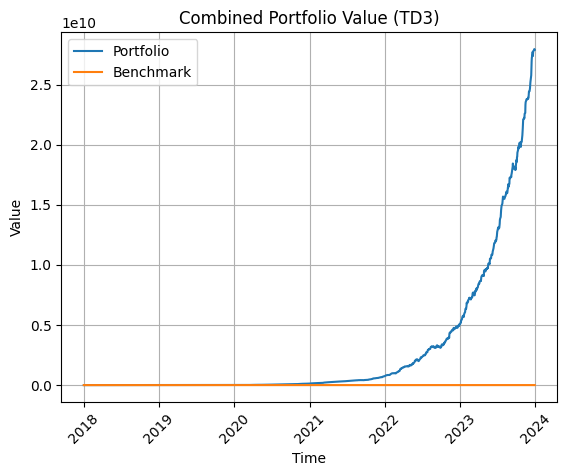

OOS2 Metrics (TD3):


,Portfolio Total Return (%),Portfolio Annualized Return (%),Portfolio Annualized Vol (%),Portfolio Sharpe,Portfolio Sortino,Portfolio Turnover,Benchmark Total Return (%),Benchmark Annualized Return (%),Benchmark Annualized Vol (%),Benchmark Sharpe,Benchmark Sortino,IC,RankIC
0,23.108039,24.223874,13.461067,1.421413,2.022683,54.229239,17.171515,18.001854,10.058344,1.283682,1.698985,0.80019,0.80341


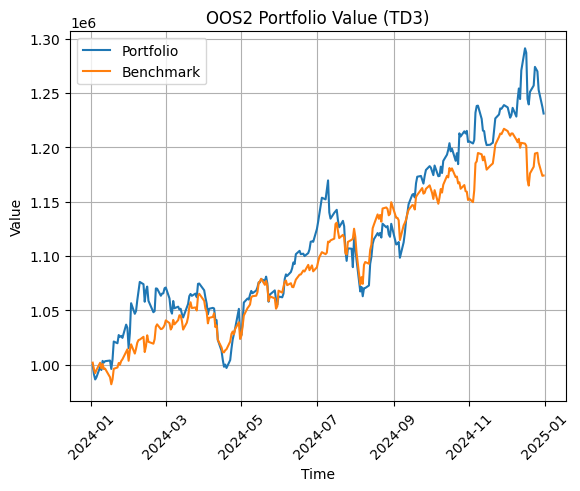

In [ ]:
# Combine Train+OOS1
combined_features = np.concatenate([train_features, oos1_features], axis=0)
combined_returns  = np.concatenate([train_returns,  oos1_returns],  axis=0)
combined_rf = np.concatenate([rf_train, rf_oos1], axis=0)
combined_bench_mark_returns = np.concatenate([train_bench_mark_returns, oos1_bench_mark_returns], axis=0)
combined_dates = np.concatenate([train_dates, oos1_dates], axis=0)

train_plus_oos1_env = PortfolioEnv(
    feature_array=combined_features,
    return_array=combined_returns,
    long_short=False,
    short_limit=1.0,
    rf_rate=combined_rf,
    borrow_cost=0.01,
    transaction_cost=0.001,
    initial_capital=1_000_000
)

epochs = 512//2
total_timesteps = epochs * (len(combined_features) - 1)

model_td3_retrain = TD3(
    "MlpPolicy",
    train_plus_oos1_env,
    verbose=1,
    learning_rate=1e-4,
    device="cuda",
    buffer_size=(len(train_features) - 1) * 25,
    train_freq=5,
    batch_size=(len(train_features) - 1),
    learning_starts=(len(train_features) - 1) * 25
)
model_td3_retrain.learn(
    total_timesteps=total_timesteps,
    # callback=eval_callback2
)

df_combined_td3 = run_backtest(train_plus_oos1_env, model_td3_retrain, dates=combined_dates, benchmark_returns=combined_bench_mark_returns)
combined_metrics_td3 = compute_performance_metrics(df_combined_td3,rf_rate=combined_rf)
print("Combined Metrics (TD3):")
display(pd.DataFrame([combined_metrics_td3]))
plot_pnl_curve(df_combined_td3, title="Combined Portfolio Value (TD3)")

# OOS2
oos2_env = PortfolioEnv(
    feature_array=oos2_features,
    return_array=oos2_returns,
    long_short=False,
    short_limit=1.0,
    rf_rate=rf_oos2,
    borrow_cost=0.01,
    transaction_cost=0.001,
    initial_capital=1_000_000
)

df_oos2_td3 = run_backtest(oos2_env, model_td3_retrain, dates=oos2_dates,benchmark_returns=oos2_bench_mark_returns)
oos2_metrics_td3 = compute_performance_metrics(df_oos2_td3,rf_rate=rf_oos2)
print("OOS2 Metrics (TD3):")
display(pd.DataFrame([oos2_metrics_td3]))
plot_pnl_curve(df_oos2_td3, title="OOS2 Portfolio Value (TD3)")

In [ ]:
oos2_metrics_td3

{'Portfolio Total Return (%)': np.float64(23.108039484960674),
 'Portfolio Annualized Return (%)': np.float64(24.22387378617308),
 'Portfolio Annualized Vol (%)': np.float64(13.461066869830232),
 'Portfolio Sharpe': np.float64(1.4214127877556786),
 'Portfolio Sortino': np.float64(2.0226834374835385),
 'Portfolio Turnover': np.float64(54.229239463822424),
 'Benchmark Total Return (%)': np.float32(17.171515),
 'Benchmark Annualized Return (%)': np.float32(18.001854),
 'Benchmark Annualized Vol (%)': np.float64(10.058344400482515),
 'Benchmark Sharpe': np.float64(1.2836817576585242),
 'Benchmark Sortino': np.float64(1.698985372450147),
 'IC': np.float64(0.8001904306296128),
 'RankIC': np.float64(0.8034101126081034)}

In [ ]:
oos2_env.history_weights

[array([3.02808224e-06, 3.02232109e-06, 6.69511820e-02, 2.98424063e-06,
        2.97045096e-06, 5.90854782e-02, 2.95270500e-06, 2.93306342e-06,
        2.99441211e-06, 3.00249798e-06, 3.08797745e-06, 2.99972333e-06,
        5.68192815e-02, 3.05882777e-06, 3.05751977e-06, 3.12531600e-06,
        2.97671034e-06, 2.96762206e-06, 6.52579376e-02, 3.04638044e-06,
        3.01438127e-06, 6.68402123e-02, 6.60421665e-02, 3.01154344e-06,
        6.75757148e-02, 6.52709293e-02, 3.02525116e-06, 3.04810690e-06,
        2.95613731e-06, 5.40613910e-02, 3.02815560e-06, 3.02745513e-06,
        2.75869655e-02, 2.95848137e-06, 6.36630687e-02, 1.01387705e-02,
        6.40078669e-02, 6.69623135e-02, 3.82698013e-06, 6.71643828e-02,
        6.58054802e-02, 6.66876946e-02, 3.05290009e-06]),
 array([4.83371223e-02, 6.34545281e-02, 6.47314728e-02, 6.37972813e-02,
        2.93107817e-06, 6.26407363e-02, 2.89419967e-06, 2.93293627e-06,
        2.94412097e-06, 2.87474712e-06, 2.83658659e-06, 2.93718333e-06,
      

In [ ]:
model_td3_retrain.save("td3_retrained_model")
model_td3_retrain.save('/content/drive/My Drive/LLM_RL_Data/td3_retrained_model_0418')

## Final Result

In [32]:
from stable_baselines3 import TD3
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.env_checker import check_env

# Combine Train+OOS1
combined_features = np.concatenate([train_features, oos1_features], axis=0)
combined_returns  = np.concatenate([train_returns,  oos1_returns],  axis=0)
combined_rf = np.concatenate([rf_train, rf_oos1], axis=0)
combined_bench_mark_returns = np.concatenate([train_bench_mark_returns, oos1_bench_mark_returns], axis=0)
combined_dates = np.concatenate([train_dates, oos1_dates], axis=0)

train_plus_oos1_env = PortfolioEnv(
    feature_array=combined_features,
    return_array=combined_returns,
    long_short=False,
    short_limit=1.0,
    rf_rate=combined_rf,
    borrow_cost=0.01,
    transaction_cost=0.001,
    initial_capital=1_000_000
)

# OOS2
oos2_env = PortfolioEnv(
    feature_array=oos2_features,
    return_array=oos2_returns,
    long_short=False,
    short_limit=1.0,
    rf_rate=rf_oos2,
    borrow_cost=0.01,
    transaction_cost=0.001,
    initial_capital=1_000_000)

In [33]:
model_loaded_ = TD3.load("td3_retrained_model", env=train_plus_oos1_env)
# model_loaded_ = TD3.load('/content/drive/My Drive/LLM_RL_Data/td3_retrained_model_0331_simplified', env=train_plus_oos1_env)
model_loaded_

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Combined Metrics (TD3):


,Portfolio Total Return (%),Portfolio Annualized Return (%),Portfolio Annualized Vol (%),Portfolio Sharpe,Portfolio Sortino,Portfolio Turnover,Benchmark Total Return (%),Benchmark Annualized Return (%),Benchmark Annualized Vol (%),Benchmark Sharpe,Benchmark Sortino,IC,RankIC
0,2.866192e+06,469.280918,22.781068,20.51484,32.750561,83.987962,119.023636,16.484821,20.13211,0.722918,0.859126,0.892577,0.877636


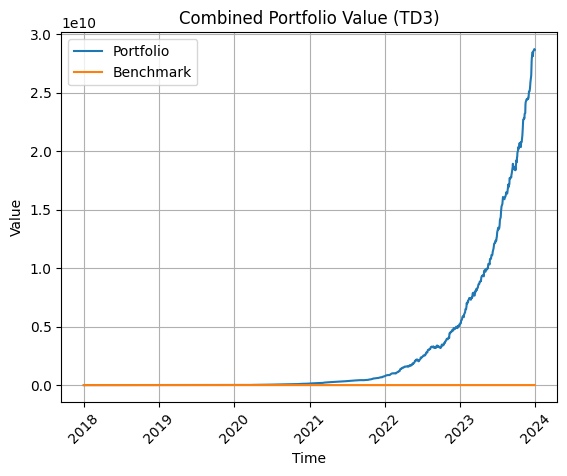

In [34]:
df_combined_td3_ = run_backtest(train_plus_oos1_env, model_loaded_, dates=combined_dates, benchmark_returns=combined_bench_mark_returns)
combined_metrics_td3_ = compute_performance_metrics(df_combined_td3_,rf_rate=combined_rf)
print("Combined Metrics (TD3):")
display(pd.DataFrame([combined_metrics_td3_]))
plot_pnl_curve(df_combined_td3_, title="Combined Portfolio Value (TD3)")

OOS2 Metrics (TD3):


,Portfolio Total Return (%),Portfolio Annualized Return (%),Portfolio Annualized Vol (%),Portfolio Sharpe,Portfolio Sortino,Portfolio Turnover,Benchmark Total Return (%),Benchmark Annualized Return (%),Benchmark Annualized Vol (%),Benchmark Sharpe,Benchmark Sortino,IC,RankIC
0,23.649641,24.769454,13.45566,1.46253,2.080359,52.481693,17.171383,17.764748,10.057637,1.260197,1.667786,0.800385,0.804204


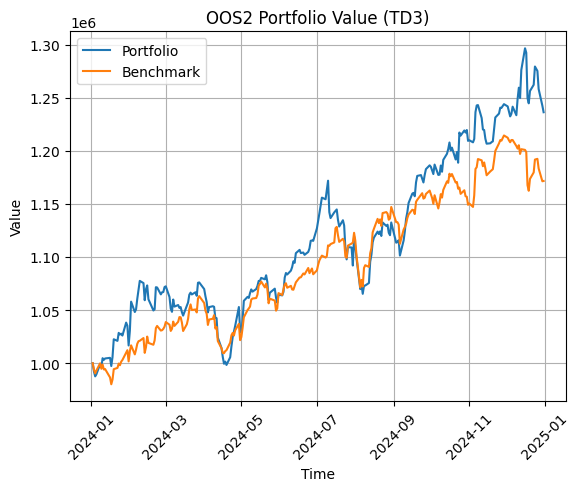

In [35]:
oos2_bench_mark_returns_ = oos2_bench_mark_returns
oos2_bench_mark_returns_[0] = 0
df_oos2_td3_ = run_backtest(oos2_env, model_loaded_, dates=oos2_dates,benchmark_returns=oos2_bench_mark_returns_)
oos2_metrics_td3_ = compute_performance_metrics(df_oos2_td3_,rf_rate=rf_oos2)
print("OOS2 Metrics (TD3):")
display(pd.DataFrame([oos2_metrics_td3_]))
plot_pnl_curve(df_oos2_td3_, title="OOS2 Portfolio Value (TD3)")

In [36]:
df_oos2_td3_

,date,portfolio_value,daily_return,action,weights,turnover,benchmark_return
0,2024-01-02,1.000000e+06,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,0.000000
1,2024-01-03,9.922792e+05,-0.007721,"[2.9802322e-07, 0.0058186054, 10.0, 0.0, 0.0, ...","[3.0280829790381475e-06, 3.0223218211432364e-0...",0.999997,-0.006057
2,2024-01-04,9.876134e+05,-0.004702,"[9.713955, 9.99907, 10.0, 10.0, 0.0, 10.0, 0.0...","[0.04833698609348511, 0.06345453619158872, 0.0...",0.538514,-0.003563
3,2024-01-05,9.896167e+05,0.002028,"[0.0, 10.0, 10.0, 10.0, 0.0, 9.961678, 0.0, 0....","[2.6950728826349024e-06, 0.05911246996110261, ...",0.426306,0.002803
4,2024-01-08,9.991937e+05,0.009678,"[0.0, 9.994961, 10.0, 9.999964, 0.0, 10.0, 0.6...","[2.82472604993259e-06, 0.06338943248245742, 0....",0.353300,0.006768
...,...,...,...,...,...,...,...
247,2024-12-24,1.279570e+06,0.013632,"[0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 1.525229, 9.90...","[3.517341118366831e-06, 3.5571107142810484e-06...",0.651248,0.010258
248,2024-12-26,1.275399e+06,-0.003259,"[0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 6.994115, 6.30...","[4.183063608438403e-06, 4.195636803695157e-06,...",0.378376,0.000590
249,2024-12-27,1.258287e+06,-0.013417,"[0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 9.994553, 0.00...","[3.926431712952675e-06, 3.8737809475110485e-06...",0.160386,-0.007624
250,2024-12-30,1.242623e+06,-0.012449,"[0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 9.999576, 0.00...","[3.732832137759155e-06, 3.6826979779731804e-06...",0.189136,-0.010178


# Rulebased

In [37]:
pip install wrds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.3 MB/s eta 0:00:00


In [40]:
import pandas as pd
import statsmodels.api as sm
import wrds

# Connect to WRDS using your WRDS username
db = wrds.Connection(wrds_username="wl2834")
ff_df = db.raw_sql("""
    SELECT date, mktrf, smb, hml, umd, rmw, cma, rf
    FROM ff.fivefactors_daily
    WHERE date >= '2017-01-01'
""")
ff_df['date'] = pd.to_datetime(ff_df['date'])



def ff5_return_decomposition(returns_df, factors_df,
                             date_col='date',
                             ret_col='strategy',
                             rf_col='rf',
                             factor_cols=['mktrf','smb','hml','rmw','cma','umd']):
    """
    参数
    ----
    returns_df : pd.DataFrame
        至少包含 [date_col, ret_col]
    factors_df : pd.DataFrame
        至少包含 [date_col] + factor_cols + [rf_col]
    返回
    ----
    coef      : pd.Series
        回归系数，包括常数项
    contrib   : pd.DataFrame
        每期因子贡献 = coef[f] * factor_return
        另含常数项贡献和残差项
    summary   : statsmodels RegressionResults
        完整回归结果对象
    """
    # 合并数据
    df = (
        returns_df[[date_col, ret_col]]
        .merge(factors_df[[date_col] + factor_cols + [rf_col]],
               on=date_col, suffixes=('','_fac'))
        .dropna()
        .set_index(date_col)
    )
    # 计算超额收益
    y = df[ret_col] - df[rf_col]
    # 因子矩阵
    X = df[factor_cols]
    X = sm.add_constant(X)

    X = X.astype(np.float64)
    y = y.astype(np.float64)

    # OLS 回归
    model = sm.OLS(y, X).fit()
    coef = model.params

    # 因子贡献 = 因子暴露 × 因子值
    contrib = X.multiply(coef, axis=1)
    contrib['residual'] = model.resid
    contrib['total_excess_ret'] = y

    return coef, contrib, model



Enter your WRDS username [wl2834]:wl2834
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [41]:
ff_df_oos = ff_df[(ff_df['date'] > oos2_start_date) & (ff_df['date'] < oos2_end_date)].reset_index(drop=True)
ff_df_oos

,date,mktrf,smb,hml,umd,rmw,cma,rf
0,2024-01-02,-0.007,-0.0026,0.0079,-0.0221,0.0066,0.0064,0.00022
1,2024-01-03,-0.0101,-0.0192,-0.0014,0.0058,0.0035,-0.0018,0.00022
2,2024-01-04,-0.0033,0.0024,0.0009,-0.0033,-0.0043,0.0024,0.00022
3,2024-01-05,0.0015,-0.0059,0.0065,-0.0028,0.0011,-0.0015,0.00022
4,2024-01-08,0.0149,0.0055,-0.0131,0.0088,-0.0098,-0.0049,0.00022
...,...,...,...,...,...,...,...,...
246,2024-12-23,0.0061,-0.0085,-0.0019,-0.0008,0.0028,0.0066,0.00017
247,2024-12-24,0.0111,-0.0012,-0.0005,0.0067,-0.0013,-0.0037,0.00017
248,2024-12-26,0.0002,0.0109,-0.0019,0.0001,-0.0044,0.0035,0.00017
249,2024-12-27,-0.0117,-0.0044,0.0056,-0.0088,0.0041,0.0003,0.00017


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

def run_backtest(env, model, dates=None, benchmark_returns=None):
    """
    Runs the portfolio environment with a trained RL model and records daily data:
      - 'date'
      - 'portfolio_value'
      - 'daily_return'
      - 'action' (raw)
      - 'weights'
      - 'turnover'

    Optionally, accepts:
      - dates: list/array of date stamps corresponding to env's time steps.
      - benchmark_returns: either a single np.array of daily benchmark returns
        (backwards compatible) or a dict where keys are benchmark names and values
        are the corresponding np.array of daily returns.

    Returns a Pandas DataFrame with the recorded columns and, if provided, benchmark columns:
      - For a dict input, columns will be named "benchmark_<name>".
    """
    obs, info = env.reset()
    done = False

    # starting cash allocation: cash + stocks (n_stocks + cash)
    all_cash = np.zeros(env.n_stocks + 1, dtype=np.float32)
    all_cash[0] = 1.0

    records = [{
        "date": dates[env._current_step] if dates is not None else env._current_step,
        "portfolio_value": env.portfolio_value,
        "daily_return": 0,
        "action": all_cash.copy(),
        "weights": all_cash.copy(),
        "turnover": 0
    }]

    step_count = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)

        cur_date = dates[env._current_step] if (dates is not None and env._current_step < len(dates)) else step_count

        records.append({
            "date": cur_date,
            "portfolio_value": env.portfolio_value,
            "daily_return": reward,
            "action": action.copy(),
            "weights": env.weights.copy(),
            "turnover": info.get('turnover', np.nan)
        })
        step_count += 1

    df = pd.DataFrame(records)

    # Attach benchmark returns: if dict, add each as a new column with prefix "benchmark_"
    if benchmark_returns is not None:
        if isinstance(benchmark_returns, dict):
            for bench_name, bench_returns in benchmark_returns.items():
                df[f"benchmark_{bench_name}"] = bench_returns[:len(df)]
        else:
            df['benchmark_return'] = benchmark_returns[:len(df)]

    return df


# def compute_performance_metrics(df, trading_days=252, rf_rate=None):
#     """
#     Computes performance metrics for the portfolio and, if available, for each benchmark.

#     Portfolio metrics include:
#       - Total Return, Annualized Return, Annualized Volatility,
#       - Sharpe and Sortino ratios,
#       - Average Turnover.

#     For each benchmark (columns starting with "benchmark_"), the function computes similar metrics and:
#       - The Pearson (IC) and Spearman (rankIC) correlations between the portfolio and benchmark daily returns.

#     Returns a nested dictionary:
#       {
#          "Portfolio": { ... portfolio metrics ... },
#          "Benchmarks": {
#              "<bench_name>": { ... benchmark metrics ... },
#              ...
#          }
#       }
#     """
#     # Portfolio calculations
#     rets = df['daily_return'].values
#     portf_vals = df['portfolio_value'].values
#     total_return = (portf_vals[-1] / portf_vals[0]) - 1.0
#     avg_daily = np.mean(rets)
#     ann_ret = total_return
#     std_daily = np.std(rets, ddof=1)
#     ann_vol = std_daily * np.sqrt(trading_days)

#     # Compute annualized risk-free rate if provided
#     if rf_rate is not None and len(rf_rate) > 0:
#         avg_rf = np.mean(rf_rate)
#         ann_rf = (1 + avg_rf)**trading_days - 1.0
#     else:
#         ann_rf = 0.0

#     print(ann_rf)

#     sharpe = (ann_ret - ann_rf) / ann_vol if ann_vol > 1e-12 else np.nan

#     neg_rets = rets[rets < 0]
#     if len(neg_rets) > 1:
#         dd = np.std(neg_rets, ddof=1)
#         ann_dd = dd * np.sqrt(trading_days)
#         sortino = (ann_ret - ann_rf) / ann_dd if ann_dd > 1e-12 else np.nan
#     else:
#         sortino = np.nan

#     portfolio_metrics = {
#         "Total Return (%)": total_return * 100,
#         "Annualized Return (%)": ann_ret * 100,
#         "Annualized Vol (%)": ann_vol * 100,
#         "Sharpe": sharpe,
#         "Sortino": sortino,
#         "Turnover (%)": np.nanmean(df['turnover']) * 100
#     }

#     # Benchmark metrics: look for columns that start with "benchmark_"
#     benchmarks_metrics = {}
#     for col in df.columns:
#         if col.startswith("benchmark_"):
#             bench_name = col[len("benchmark_"):]
#             bmk_rets = df[col].values
#             initial_value = portf_vals[0]
#             benchmark_cumval = (1 + pd.Series(bmk_rets)).cumprod() * initial_value
#             total_bmk_return = (benchmark_cumval.iloc[-1] / benchmark_cumval.iloc[0]) - 1.0
#             avg_bmk_daily = np.mean(bmk_rets)
#             ann_bmk_ret = (benchmark_cumval.iloc[-1] / benchmark_cumval.iloc[0]) - 1.0
#             std_bmk_daily = np.std(bmk_rets, ddof=1)
#             ann_bmk_vol = std_bmk_daily * np.sqrt(trading_days)
#             sharpe_bmk = (ann_bmk_ret - ann_rf) / ann_bmk_vol if ann_bmk_vol > 1e-12 else np.nan

#             neg_bmk = bmk_rets[bmk_rets < 0]
#             if len(neg_bmk) > 1:
#                 dd_bmk = np.std(neg_bmk, ddof=1)
#                 ann_bmk_dd = dd_bmk * np.sqrt(trading_days)
#                 sortino_bmk = (ann_bmk_ret - ann_rf) / ann_bmk_dd if ann_bmk_dd > 1e-12 else np.nan
#             else:
#                 sortino_bmk = np.nan

#             try:
#                 IC, _ = pearsonr(rets, bmk_rets)
#             except Exception:
#                 IC = np.nan
#             try:
#                 rankIC, _ = spearmanr(rets, bmk_rets)
#             except Exception:
#                 rankIC = np.nan

#             excess_ret_over_bmk = rets - bmk_rets
#             excess_ret_over_bmk_std = np.std(excess_ret_over_bmk, ddof=1)
#             IR_daily = np.mean(excess_ret_over_bmk) / excess_ret_over_bmk_std
#             IR_ann = IR_daily * np.sqrt(trading_days)


#             benchmarks_metrics[bench_name] = {
#                 "Total Return (%)": total_bmk_return * 100,
#                 "Annualized Return (%)": ann_bmk_ret * 100,
#                 "Annualized Vol (%)": ann_bmk_vol * 100,
#                 "Sharpe": sharpe_bmk,
#                 "Sortino": sortino_bmk,
#                 # "IC": IC,
#                 # "RankIC": rankIC,
#                 # "Annualized IR": IR_ann
#             }
#     portfolio_metrics["IC"]= IC
#     portfolio_metrics["RankIC"]= rankIC
#     portfolio_metrics["Annualized IR"]= IR_ann

#     metrics = {
#         "Portfolio": portfolio_metrics,
#         "Benchmarks": benchmarks_metrics
#     }

#     return metrics

def compute_performance_metrics(df, trading_days=252, rf_rate=None):
    # Basic series
    rets       = df['daily_return'].values
    portf_vals = df['portfolio_value'].values

    # Total & annualized return
    total_return = portf_vals[-1] / portf_vals[0] - 1.0
    ann_ret      = total_return

    # Volatility
    std_daily = np.std(rets, ddof=1)
    ann_vol   = std_daily * np.sqrt(trading_days)

    # Risk‑free compound
    if rf_rate is not None and len(rf_rate) > 0:
        avg_rf = np.mean(rf_rate)
        ann_rf  = (1 + avg_rf)**trading_days - 1.0
    else:
        ann_rf = 0.0

    # Sharpe & Sortino
    sharpe = (ann_ret - ann_rf) / ann_vol if ann_vol > 1e-12 else np.nan
    neg_rets = rets[rets < 0]
    if len(neg_rets) > 1:
        dd_std   = np.std(neg_rets, ddof=1) * np.sqrt(trading_days)
        sortino  = (ann_ret - ann_rf) / dd_std if dd_std > 1e-12 else np.nan
    else:
        sortino = np.nan

    # **Max Drawdown**
    running_max = np.maximum.accumulate(portf_vals)
    drawdowns   = (portf_vals / running_max) - 1
    max_dd      = drawdowns.min()

    # Build portfolio metrics
    portfolio_metrics = {
        "Total Return (%)":       total_return * 100,
        "Annualized Return (%)":  ann_ret * 100,
        "Annualized Vol (%)":     ann_vol * 100,
        "Sharpe":                 sharpe,
        "Sortino":                sortino,
        "Turnover (%)":           np.nanmean(df['turnover']) * 100,
        "Max Drawdown (%)":       max_dd * 100
    }

    # Benchmarks
    benchmarks_metrics = {}
    for col in df.columns:
        if not col.startswith("benchmark_"):
            continue
        name    = col[len("benchmark_"):]
        bmk_rets= df[col].values

        # Build cumulative value series at same start
        init_val      = portf_vals[0]
        bmk_cumval    = (1 + pd.Series(bmk_rets)).cumprod() * init_val
        total_bmk_ret = bmk_cumval.iloc[-1] / bmk_cumval.iloc[0] - 1.0

        avg_bmk_daily = np.mean(bmk_rets)
        std_bmk_daily = np.std(bmk_rets, ddof=1)
        ann_bmk_vol   = std_bmk_daily * np.sqrt(trading_days)
        sharpe_bmk    = (total_bmk_ret - ann_rf) / ann_bmk_vol if ann_bmk_vol > 1e-12 else np.nan

        # Sortino for benchmark
        neg_bmk = bmk_rets[bmk_rets < 0]
        if len(neg_bmk) > 1:
            bmk_dd_std  = np.std(neg_bmk, ddof=1) * np.sqrt(trading_days)
            sortino_bmk = (total_bmk_ret - ann_rf) / bmk_dd_std if bmk_dd_std > 1e-12 else np.nan
        else:
            sortino_bmk = np.nan

        # **Benchmark Max Drawdown**
        bmk_running_max = bmk_cumval.cummax()
        bmk_drawdowns   = (bmk_cumval / bmk_running_max) - 1
        max_dd_bmk      = bmk_drawdowns.min()

        benchmarks_metrics[name] = {
            "Total Return (%)":       total_bmk_ret * 100,
            "Annualized Return (%)":  total_bmk_ret * 100,
            "Annualized Vol (%)":     ann_bmk_vol * 100,
            "Sharpe":                 sharpe_bmk,
            "Sortino":                sortino_bmk,
            "Max Drawdown (%)":       max_dd_bmk * 100
        }

    return {
        "Portfolio":  portfolio_metrics,
        "Benchmarks": benchmarks_metrics
    }



def plot_pnl_curve(df, title="Portfolio Value Over Time", save_path="portfolio_plot.png"):
    """
    Plots the portfolio value over time along with cumulative value curves
    of all benchmarks (columns starting with "benchmark_"). Each benchmark's
    cumulative value is computed assuming it starts from the same initial portfolio value.

    The plot is saved to the file specified by 'save_path'.
    """
    plt.figure(figsize=(10, 6))
    x = df['date'] if 'date' in df.columns else range(len(df))

    # Plot portfolio value
    plt.plot(x, df['portfolio_value'], label="RL")

    # Plot each benchmark curve
    for col in df.columns:
        if col.startswith("benchmark_"):
            initial_value = df['portfolio_value'].iloc[0]
            benchmark_cumval = (1 + df[col]).cumprod() * initial_value
            bench_name = col[len("benchmark_"):]
            plt.plot(x, benchmark_cumval, label=bench_name)

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)

    # Save the plot before showing it
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()



In [43]:
oos2_bench_mark_returns_ = oos2_bench_mark_returns.copy()
oos2_bench_mark_returns_[0] = 0

# ret_series_tech = np.append(ret_series_0.values,0)
# ret_series_tech[0] = 0

# ret_series_sen = np.append(ret_series_1.values,0)
# ret_series_sen[0] = 0

# ret_series_combined = np.append(ret_series_05.values,0)
# ret_series_combined[0] = 0

In [44]:
bench_mark_dict = {'buy-and-hold':oos2_bench_mark_returns_}
# bench_mark_dict = {'buy-and-hold':oos2_bench_mark_returns_,'technicals':ret_series_tech,'combined':ret_series_combined}

OOS2 Metrics (TD3):


,Portfolio,Benchmarks
0,"{'Total Return (%)': 23.64964095701245, 'Annua...",{'buy-and-hold': {'Total Return (%)': 17.17138...


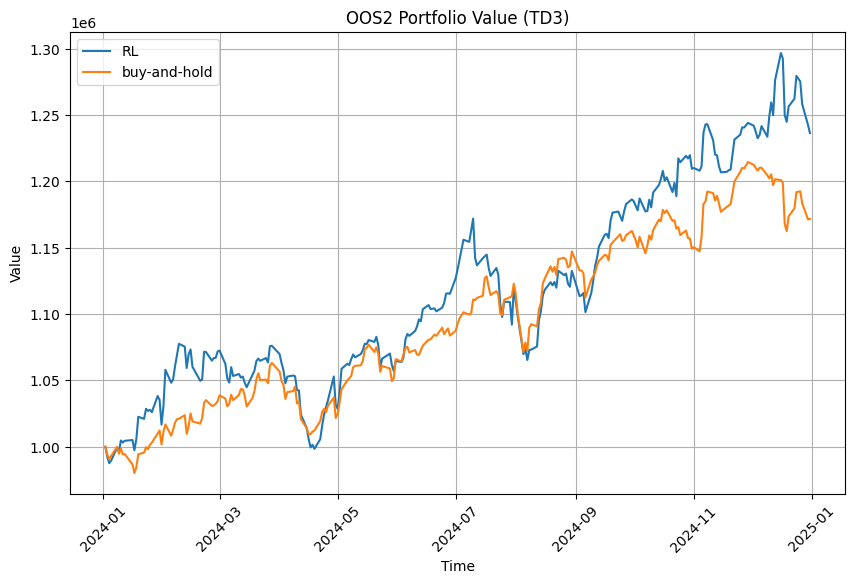

In [45]:

df_oos2_td3_ = run_backtest(oos2_env, model_loaded_, dates=oos2_dates,benchmark_returns=bench_mark_dict)
oos2_metrics_td3_ = compute_performance_metrics(df_oos2_td3_,rf_rate=rf_oos2)
print("OOS2 Metrics (TD3):")
display(pd.DataFrame([oos2_metrics_td3_]))
plot_pnl_curve(df_oos2_td3_, title="OOS2 Portfolio Value (TD3)")

In [46]:
metrics = compute_performance_metrics(df_oos2_td3_, rf_rate=rf_oos2)

# Create a new dictionary that flattens the structure, where keys are the strategy names
# (Portfolio and each benchmark) and values are the corresponding metrics dictionaries.
all_metrics = {"Portfolio": metrics["Portfolio"]}
for bench_name, bench_metrics in metrics["Benchmarks"].items():
    all_metrics[bench_name] = bench_metrics

# Convert the dictionary to a DataFrame, and transpose it so that each row represents a strategy.
metrics_df = pd.DataFrame(all_metrics).transpose()

metrics_df

,Total Return (%),Annualized Return (%),Annualized Vol (%),Sharpe,Sortino,Turnover (%),Max Drawdown (%)
Portfolio,23.649641,23.649641,13.455660,1.379308,1.961980,52.273432,-9.094408
buy-and-hold,17.171383,17.171383,10.057637,1.201201,1.589708,NaN,-5.057609


In [47]:
print(metrics_df)

              Total Return (%)  Annualized Return (%)  Annualized Vol (%)  \
Portfolio            23.649641              23.649641           13.455660   
buy-and-hold         17.171383              17.171383           10.057637   

                Sharpe   Sortino  Turnover (%)  Max Drawdown (%)  
Portfolio     1.379308  1.961980     52.273432         -9.094408  
buy-and-hold  1.201201  1.589708           NaN         -5.057609  


In [48]:
df_oos2_td3_ff = pd.merge(df_oos2_td3_, ff_df_oos, left_on='date', right_on='date', how = 'inner')
df_oos2_td3_ff = df_oos2_td3_ff[1:]
df_oos2_td3_ff

,date,portfolio_value,daily_return,action,weights,turnover,benchmark_buy-and-hold,mktrf,smb,hml,umd,rmw,cma,rf
1,2024-01-03,9.922792e+05,-0.007721,"[2.9802322e-07, 0.0058186054, 10.0, 0.0, 0.0, ...","[3.0280829790381475e-06, 3.0223218211432364e-0...",0.999997,-0.006057,-0.0101,-0.0192,-0.0014,0.0058,0.0035,-0.0018,0.00022
2,2024-01-04,9.876134e+05,-0.004702,"[9.713955, 9.99907, 10.0, 10.0, 0.0, 10.0, 0.0...","[0.04833698609348511, 0.06345453619158872, 0.0...",0.538514,-0.003563,-0.0033,0.0024,0.0009,-0.0033,-0.0043,0.0024,0.00022
3,2024-01-05,9.896167e+05,0.002028,"[0.0, 10.0, 10.0, 10.0, 0.0, 9.961678, 0.0, 0....","[2.6950728826349024e-06, 0.05911246996110261, ...",0.426306,0.002803,0.0015,-0.0059,0.0065,-0.0028,0.0011,-0.0015,0.00022
4,2024-01-08,9.991937e+05,0.009678,"[0.0, 9.994961, 10.0, 9.999964, 0.0, 10.0, 0.6...","[2.82472604993259e-06, 0.06338943248245742, 0....",0.353300,0.006768,0.0149,0.0055,-0.0131,0.0088,-0.0098,-0.0049,0.00022
5,2024-01-09,9.963328e+05,-0.002863,"[0.0, 10.0, 9.999945, 6.768441, 0.0, 10.0, 0.0...","[3.748648145133558e-06, 0.08236552636808236, 0...",0.740959,-0.005145,-0.0021,-0.0075,-0.009,0.01,-0.003,-0.0018,0.00022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2024-12-23,1.262361e+06,0.004673,"[0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 8.89...","[3.025343774214596e-06, 3.034101993249528e-06,...",0.521134,0.005200,0.0061,-0.0085,-0.0019,-0.0008,0.0028,0.0066,0.00017
247,2024-12-24,1.279570e+06,0.013632,"[0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 1.525229, 9.90...","[3.517341118366831e-06, 3.5571107142810484e-06...",0.651248,0.010258,0.0111,-0.0012,-0.0005,0.0067,-0.0013,-0.0037,0.00017
248,2024-12-26,1.275399e+06,-0.003259,"[0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 6.994115, 6.30...","[4.183063608438403e-06, 4.195636803695157e-06,...",0.378376,0.000590,0.0002,0.0109,-0.0019,0.0001,-0.0044,0.0035,0.00017
249,2024-12-27,1.258287e+06,-0.013417,"[0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 9.994553, 0.00...","[3.926431712952675e-06, 3.8737809475110485e-06...",0.160386,-0.007624,-0.0117,-0.0044,0.0056,-0.0088,0.0041,0.0003,0.00017


In [50]:
coef, contrib_df, res = ff5_return_decomposition(
    returns_df=df_oos2_td3_ff, #把这个改成strategy的return df名字
    factors_df=df_oos2_td3_ff,
    date_col='date',
    ret_col='daily_return', #按照return column名字修改
    rf_col='rf',
    factor_cols=['mktrf','smb','hml','rmw','cma','umd']
)

print("factor exposure：\n", coef)
print("\n contribution：\n", contrib_df.head())
print("\regression summary\n", res.summary())

factor exposure：
 const    0.000027
mktrf    0.911057
smb     -0.169535
hml      0.046724
rmw      0.039298
cma     -0.126333
umd     -0.143393
dtype: float64

 contribution：
                const     mktrf       smb       hml       rmw       cma  \
date                                                                     
2024-01-03  0.000027 -0.009202  0.003255 -0.000065  0.000138  0.000227   
2024-01-04  0.000027 -0.003006 -0.000407  0.000042 -0.000169 -0.000303   
2024-01-05  0.000027  0.001367  0.001000  0.000304  0.000043  0.000189   
2024-01-08  0.000027  0.013575 -0.000932 -0.000612 -0.000385  0.000619   
2024-01-09  0.000027 -0.001913  0.001272 -0.000421 -0.000118  0.000227   

                 umd  residual  total_excess_ret  
date                                              
2024-01-03 -0.000832 -0.001489         -0.007941  
2024-01-04  0.000473 -0.001579         -0.004922  
2024-01-05  0.000401 -0.001523          0.001808  
2024-01-08 -0.001262 -0.001571          0.009458  

In [51]:
contrib_df.describe()

,const,mktrf,smb,hml,rmw,cma,umd,residual,total_excess_ret
count,2.500000e+02,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02,250.000000
mean,2.675708e-05,0.000702,0.000069,-0.000017,0.000004,0.000044,-0.000127,-4.682088e-16,0.000702
std,1.018479e-20,0.007612,0.001422,0.000347,0.000200,0.000581,0.001099,4.981691e-03,0.008502
min,2.675708e-05,-0.028972,-0.007137,-0.001304,-0.000601,-0.001807,-0.003011,-1.535162e-02,-0.033184
25%,2.675708e-05,-0.002779,-0.000733,-0.000266,-0.000112,-0.000300,-0.000896,-2.593594e-03,-0.003385
50%,2.675708e-05,0.000729,0.000203,-0.000019,0.000012,0.000063,-0.000100,-4.924231e-04,0.000658
75%,2.675708e-05,0.005193,0.001068,0.000195,0.000140,0.000379,0.000538,2.864684e-03,0.005577
max,2.675708e-05,0.026603,0.004272,0.001682,0.000511,0.001769,0.004015,2.124191e-02,0.026504


In [52]:
print(metrics_df)

              Total Return (%)  Annualized Return (%)  Annualized Vol (%)  \
Portfolio            23.649641              23.649641           13.455660   
buy-and-hold         17.171383              17.171383           10.057637   

                Sharpe   Sortino  Turnover (%)  Max Drawdown (%)  
Portfolio     1.379308  1.961980     52.273432         -9.094408  
buy-and-hold  1.201201  1.589708           NaN         -5.057609  


## For beamer slides

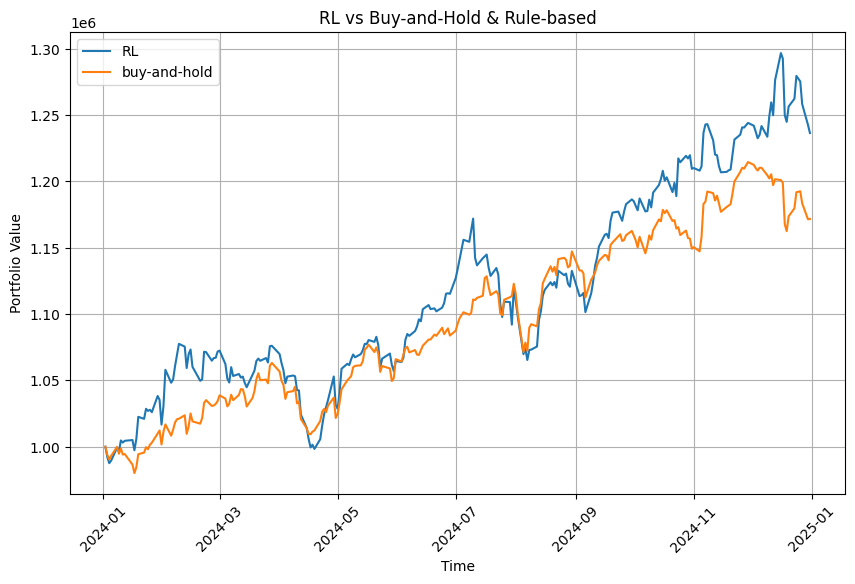

In [54]:
def plot_pnl_curve_selected(df, benchmark_names, title="Portfolio Value Over Time", save_path=None):
    """
    Plots the RL portfolio (using 'portfolio_value') along with selected benchmarks.
    For each benchmark (whose column is expected as "benchmark_<name>"), the function
    computes its cumulative performance (compounding the daily return series) starting from
    the initial portfolio value.

    Parameters:
      - df: DataFrame from run_backtest containing 'date', 'portfolio_value', and benchmark columns.
      - benchmark_names: List of benchmark names (e.g. ["buy-and-hold", "combined"]) to plot.
      - title: Plot title.
      - save_path: (Optional) path to save the plot.
    """
    if not save_path:
      save_path = f"{title}.png"
    plt.figure(figsize=(10, 6))
    x = df['date'] if 'date' in df.columns else range(len(df))

    # Plot RL portfolio value
    plt.plot(x, df['portfolio_value'], label="RL")

    # Plot selected benchmarks
    for bench in benchmark_names:
        col_name = f"benchmark_{bench}"
        if col_name in df.columns:
            initial_value = df['portfolio_value'].iloc[0]
            # Compute cumulative performance by compounding daily returns
            benchmark_cumval = (1 + df[col_name]).cumprod() * initial_value
            plt.plot(x, benchmark_cumval, label=bench)
        else:
            print(f"Warning: {col_name} not found in DataFrame.")

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


# Use the existing backtested DataFrame (df_oos2_td3_) and plot RL vs buy-and-hold & combined:
plot_pnl_curve_selected(
    df=df_oos2_td3_,
    benchmark_names=["buy-and-hold", "combined"],
    title="RL vs Buy-and-Hold & Rule-based"
)


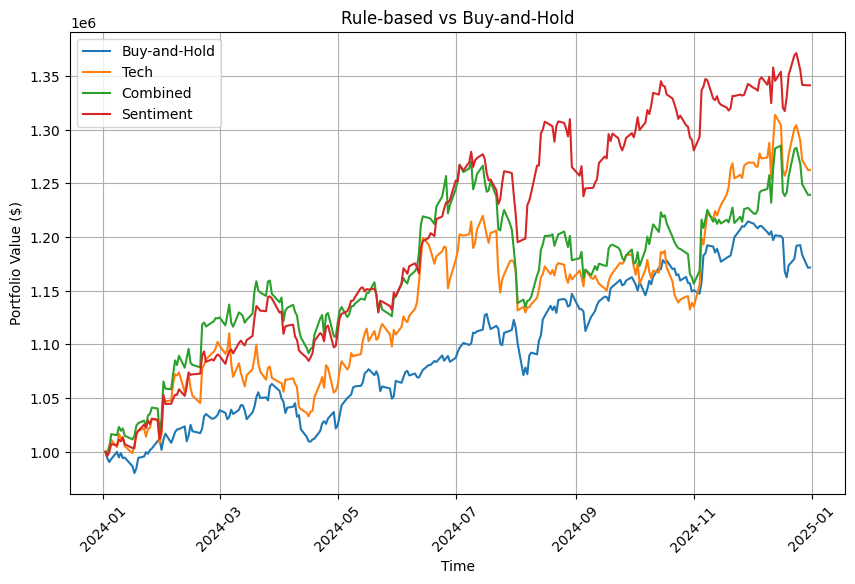

<Figure size 640x480 with 0 Axes>

In [ ]:
# Assume these numpy arrays are defined and have been adjusted as needed:
# oos2_bench_mark_returns_  (buy-and-hold returns)
# ret_series_tech           (tech returns)
# ret_series_combined       (combined returns)
# And oos2_dates is a date array matching the length of the return series.

initial_value = 1e6  # Starting portfolio value of $1,000,000

# Simulate cumulative portfolio values using numpy cumprod for each strategy.
buy_hold_values = initial_value * np.cumprod(1 + oos2_bench_mark_returns_)
tech_values     = initial_value * np.cumprod(1 + ret_series_tech)
combined_values = initial_value * np.cumprod(1 + ret_series_combined)
sentiment_values = initial_value * np.cumprod(1 + ret_series_sen)

# Create a new DataFrame for plotting.
df_sim = pd.DataFrame({
    'date': oos2_dates,
    'buy-and-hold': buy_hold_values,
    'technicals': tech_values,
    'combined': combined_values,
    'sentiment': sentiment_values
})

# Plot the performance curves.
plt.figure(figsize=(10, 6))
x = df_sim['date'] if 'date' in df_sim.columns else range(len(df_sim))
plt.plot(x, df_sim['buy-and-hold'], label="Buy-and-Hold")
plt.plot(x, df_sim['technicals'], label="Tech")
plt.plot(x, df_sim['combined'], label="Combined")
plt.plot(x, df_sim['sentiment'], label="Sentiment")
plt.title("Rule-based vs Buy-and-Hold")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.savefig("Rule-based vs Buy-and-Hold.png", bbox_inches="tight")
